In [97]:
try:
    import torch 
    import torchvision 
    print(f"torch version:{torch.__version__}")
    print(f"torch vision version:{torchvision.__version__}")
except: 
    print("Error in importing torch or torchvision")

torch version:2.8.0
torch vision version:0.23.0


In [1]:
from helper_functions import download_data, set_seeds, plot_loss_curves
from going_modular.going_modular import data_setup , engine

/Users/rishuranjan/Documents/Projects/pytorch/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/rishuranjan/Documents/Projects/pytorch/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
            destination="pizza_streak_sushi",
            remove_source=True)
image_path

[INFO] data/pizza_streak_sushi directory exists, skipping download.


PosixPath('data/pizza_streak_sushi')

In [4]:
train_dir = image_path/'train'
test_dir = image_path/'test'

#### resizing all the images into 224X224 size. 

In [5]:
from torchvision import transforms

IMG_SIZE = 224 

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

In [6]:
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### transforming the train and test dataloaders : resising them to 224*244 pixels of images.

In [41]:
from going_modular.going_modular import data_setup
import os

batch_size = 2
train_dataloader, test_dataloader,class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = batch_size,
    num_workers = (os.cpu_count()//2)
)

train_dataloader , test_dataloader , class_names

(<torch.utils.data.dataloader.DataLoader at 0x127f0c520>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]

image.shape , label

/Users/rishuranjan/Documents/Projects/pytorch/env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(1))

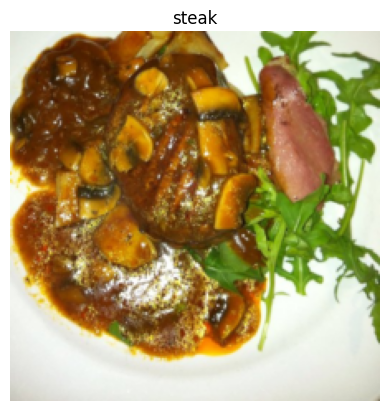

In [39]:
import matplotlib.pyplot as plt 
plt.title(class_names[label])
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.show()

In [40]:
height = 224
width = 224
colour_channels = 3
patch = 16 # mentioned in the paper as the most effective path size

number_of_patches = int((height * width)//patch**2)
number_of_patches

196

In [42]:
embedding_layer_input_shape = (height, width, colour_channels)
print("\n Input shape of an image ->",embedding_layer_input_shape)

embedding_layer_output_shape = (number_of_patches, patch**2 * colour_channels)
print("\n Output shape of an image ->",embedding_layer_output_shape)


 Input shape of an image -> (224, 224, 3)

 Output shape of an image -> (196, 768)


### number of patches for a single channel in an image = 196 and a single patch of an image with 16 height and 16 width is to take from all the 3 channels of the image. And there is how our embedding of a single patch is calculated. 768

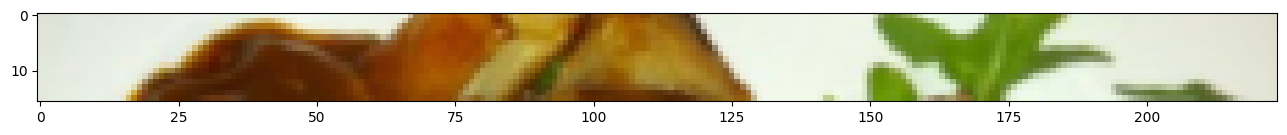

In [27]:
# imshow() expects [height, width, colour_channels]
# but our image is in [colour_channels, height, width]
# so we need to permute the dimensions
image_permuted = image.permute(1,2,0)

patch = 16
plt.figure(figsize = (patch, patch))
plt.imshow(image_permuted[:patch,:,:]);

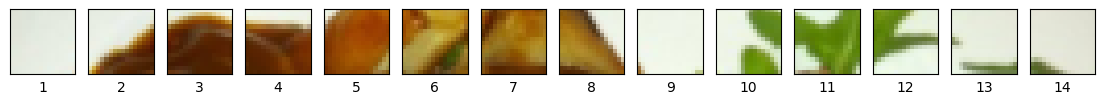

In [43]:
image_size = 224 
patch_size = 16
num_patches = (image_size // patch_size) # num of patches along one dimension

assert image_size % patch_size == 0 , "Image size must be divisible by the patch size"

fig , axs = plt.subplots ( nrows =1,
                            ncols = image_size// patch_size,
                            figsize = (num_patches , num_patches),
                            sharex = True,
                            sharey = True)

for i, patch in enumerate(range(0, image_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size,:])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [16]:
# since the height = width = 224 
# The totoal number of patches = (224/16) * (224/16) = 14 * 14 = 196
# Each patch is of size 16 * 16 and has 3 colour channels
# So the embedding size of each patch = 16 * 16 * 3 = 768
# Therefore the embedding layer output shape = (196, 768)

In [30]:
image_permuted.shape

torch.Size([224, 224, 3])

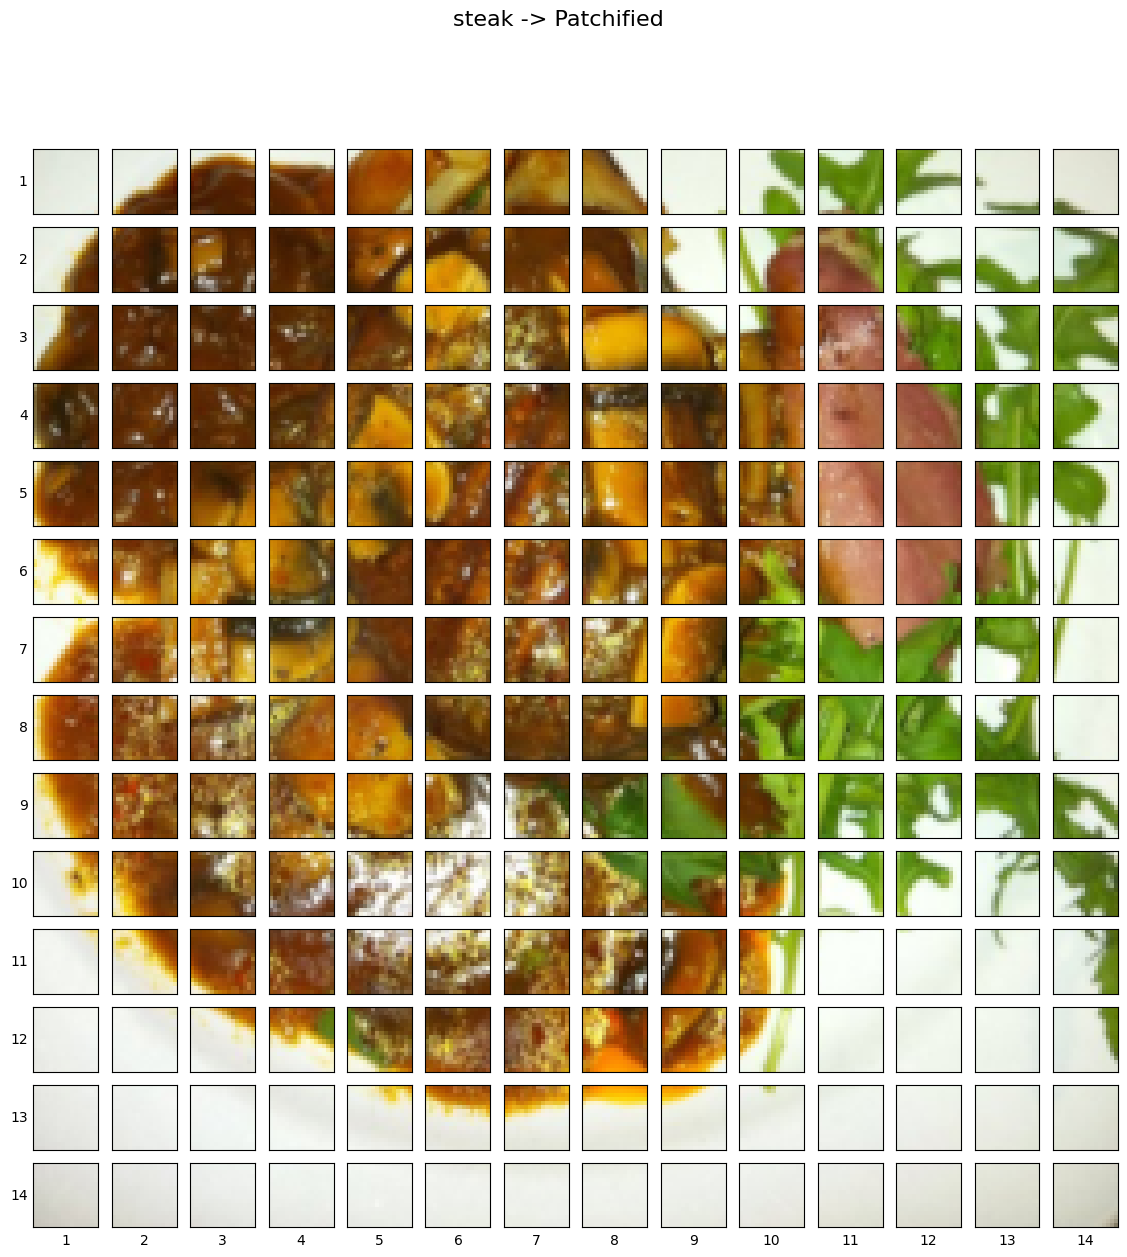

In [31]:
fig, axs = plt.subplots(nrows=image_size // patch_size, # need int not float
                        ncols=image_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i , patch_height in enumerate(range(0, image_size, patch_size)):
    for j, patch_width in enumerate(range(0, image_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,:])
        axs[i,j].set_ylabel(i+1,
        rotation="horizontal",
        horizontalalignment="right",
        verticalalignment="center")

        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

## implementing the image patches using conv2d()

In [32]:
from torch import nn 

conv2d = nn.Conv2d(in_channels=3,
                    out_channels=768,
                    kernel_size=16,
                    stride=16,
                    padding=0) # no padding as we want non-overlapping patches

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

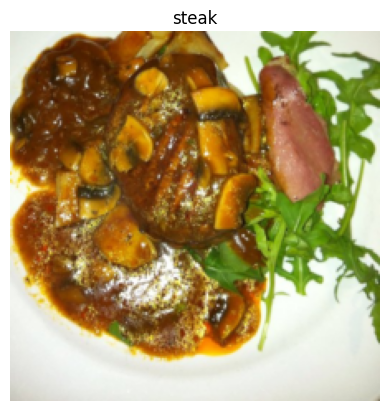

In [33]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [44]:
image_out_conv = conv2d(image.unsqueeze(0)) # add batch dimension
image_out_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [462, 337, 120, 429, 718]


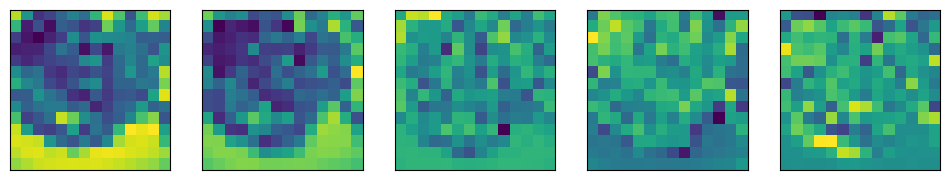

In [54]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [53]:
single_feature_map = image_out_conv[:, random_indexes[0], :, :]
single_feature_map, single_feature_map.requires_grad 

(tensor([[[-3.3860e-01, -2.5998e-01,  1.5630e-01,  2.3707e-02, -4.0793e-03,
           -8.6231e-02, -8.0010e-02,  1.7940e-01, -3.3650e-01, -5.9304e-01,
           -1.9597e-01, -1.6684e-01, -2.7285e-01, -3.9319e-01],
          [-3.5743e-01,  7.5137e-02, -1.0460e-01,  4.3921e-02, -1.4186e-02,
            5.2334e-02, -2.8151e-02,  1.9397e-01, -6.2446e-01, -3.7163e-01,
           -9.7236e-02, -1.5192e-01, -1.8800e-01, -3.3708e-01],
          [-2.3744e-01,  1.3701e-02,  1.6373e-02,  1.5155e-02,  2.9580e-02,
           -3.6698e-03, -9.6396e-02, -1.1139e-01,  2.1438e-01,  5.2789e-02,
           -1.4160e-01, -1.8593e-02, -3.0841e-01,  1.0868e-01],
          [ 6.9819e-02,  5.7579e-02, -5.8895e-02,  1.5568e-03, -7.6192e-02,
            1.2156e-01,  2.5085e-02, -1.5264e-01,  9.0457e-02, -8.0766e-02,
           -6.4797e-02,  1.0060e-02, -2.4637e-01,  1.6866e-02],
          [ 1.3414e-01, -5.8868e-02,  8.3927e-02,  8.0930e-03,  4.1555e-02,
           -9.9837e-02,  8.1192e-02, -2.0951e-01,  2.0365e-0

In [37]:
# Current tensor shape
print(f"Current tensor shape: {image_out_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [38]:
flatten = nn.Flatten(start_dim=2,# flatten feature_map_height (dimension 2)
                    end_dim=3)# flatten feature_map_width (dimension 3)

In [26]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

Original Image shape -> torch.Size([3, 224, 224])
Image feature map shape -> torch.Size([1, 3, 224, 224])
Flattened Image feature map shape -> torch.Size([1, 768, 196])


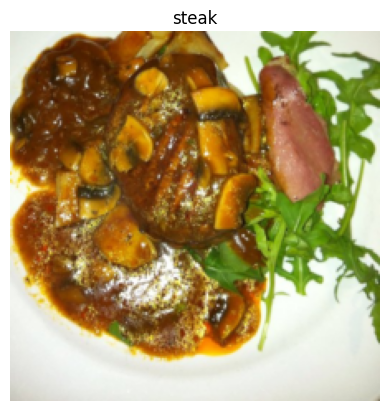

In [55]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print("Original Image shape ->",image.shape)
image_out_conv = conv2d(image.unsqueeze(0))
print('Image feature map shape ->',image.unsqueeze(0).shape)
image_out_conv_flattened = flatten(image_out_conv)
print('Flattened Image feature map shape ->',image_out_conv_flattened.shape)

In [71]:
image_out_conv_flattened_reshaped = image_out_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")


Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


### the desired input and output shapes for patch embedding layer of ViT is done!!

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

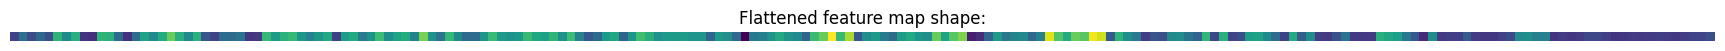

In [72]:
single_flattened_feature_map = image_out_conv_flattened_reshaped[:,:,0]

plt.figure(figsize = (22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title("Flattened feature map shape:")
plt.axis(False)

In [73]:
class PatchEmbedding(nn.Module):
    def __init__(self,in_channels=3,patch_size=16,out_channels =768,padding=0 ):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels = in_channels,
                                kernel_size = patch_size,
                                out_channels = out_channels,
                                stride = patch_size,
                                padding = 0)
        
        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    
    def forward(self,x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, "Image size must be divisible by the patch size"
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        x_reshaped = x_flattened.permute(0,2,1)
        return x_reshaped

In [74]:
patchify = PatchEmbedding()
patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [58]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

## creating the class embedding 

In [83]:
print(patch_embedded_image)
print("Shape of patch embedded image:",patch_embedded_image.shape)

tensor([[[ 7.0527e-01, -6.1825e-01,  2.3780e-01,  ..., -1.1648e-01,
           4.9989e-01,  1.3203e-02],
         [ 3.3811e-01, -5.6298e-01,  3.4437e-01,  ...,  9.4876e-02,
           4.4770e-01, -2.3131e-01],
         [ 1.5188e-01, -2.6250e-01, -6.1822e-02,  ..., -1.7607e-02,
           4.2944e-01,  4.0388e-02],
         ...,
         [ 6.5421e-01, -5.9611e-01,  2.3447e-01,  ..., -1.2229e-01,
           4.9453e-01,  3.9600e-04],
         [ 6.3596e-01, -5.8408e-01,  2.2448e-01,  ..., -1.2559e-01,
           4.8449e-01, -1.1908e-03],
         [ 5.9921e-01, -5.3499e-01,  2.5216e-01,  ..., -1.1943e-01,
           4.7406e-01,  6.1189e-03]]], grad_fn=<PermuteBackward0>)
Shape of patch embedded image: torch.Size([1, 196, 768])


In [84]:
print(patch_embedded_image)

tensor([[[ 7.0527e-01, -6.1825e-01,  2.3780e-01,  ..., -1.1648e-01,
           4.9989e-01,  1.3203e-02],
         [ 3.3811e-01, -5.6298e-01,  3.4437e-01,  ...,  9.4876e-02,
           4.4770e-01, -2.3131e-01],
         [ 1.5188e-01, -2.6250e-01, -6.1822e-02,  ..., -1.7607e-02,
           4.2944e-01,  4.0388e-02],
         ...,
         [ 6.5421e-01, -5.9611e-01,  2.3447e-01,  ..., -1.2229e-01,
           4.9453e-01,  3.9600e-04],
         [ 6.3596e-01, -5.8408e-01,  2.2448e-01,  ..., -1.2559e-01,
           4.8449e-01, -1.1908e-03],
         [ 5.9921e-01, -5.3499e-01,  2.5216e-01,  ..., -1.1943e-01,
           4.7406e-01,  6.1189e-03]]], grad_fn=<PermuteBackward0>)


In [85]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),requires_grad=True)# [batch_size, number of tokens, embedding dimension]
class_token.shape

torch.Size([1, 1, 768])

In [86]:
print(class_token[:,:,10])

tensor([[1.]], grad_fn=<SelectBackward0>)


In [87]:
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)
print(patch_embedded_image_with_class_embedding)

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 7.0527e-01, -6.1825e-01,  2.3780e-01,  ..., -1.1648e-01,
           4.9989e-01,  1.3203e-02],
         [ 3.3811e-01, -5.6298e-01,  3.4437e-01,  ...,  9.4876e-02,
           4.4770e-01, -2.3131e-01],
         ...,
         [ 6.5421e-01, -5.9611e-01,  2.3447e-01,  ..., -1.2229e-01,
           4.9453e-01,  3.9600e-04],
         [ 6.3596e-01, -5.8408e-01,  2.2448e-01,  ..., -1.2559e-01,
           4.8449e-01, -1.1908e-03],
         [ 5.9921e-01, -5.3499e-01,  2.5216e-01,  ..., -1.1943e-01,
           4.7406e-01,  6.1189e-03]]], grad_fn=<CatBackward0>)


In [88]:
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 7.0527e-01, -6.1825e-01,  2.3780e-01,  ..., -1.1648e-01,
            4.9989e-01,  1.3203e-02],
          [ 3.3811e-01, -5.6298e-01,  3.4437e-01,  ...,  9.4876e-02,
            4.4770e-01, -2.3131e-01],
          ...,
          [ 6.5421e-01, -5.9611e-01,  2.3447e-01,  ..., -1.2229e-01,
            4.9453e-01,  3.9600e-04],
          [ 6.3596e-01, -5.8408e-01,  2.2448e-01,  ..., -1.2559e-01,
            4.8449e-01, -1.1908e-03],
          [ 5.9921e-01, -5.3499e-01,  2.5216e-01,  ..., -1.1943e-01,
            4.7406e-01,  6.1189e-03]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

## creating positional embedding

In [47]:
# EQ1 suggests adding positional embedding to the patch embeddings + class token embedding
# N + 1 (N-> number of patches , 1-> class token)

In [69]:
number_of_patches = int((height * width)//patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1,number_of_patches + 1, embedding_dimension),requires_grad=True)
print(position_embedding[:,:10,:10])

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)


In [89]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.7053, 0.3817, 1.2378,  ..., 0.8835, 1.4999, 1.0132],
         [1.3381, 0.4370, 1.3444,  ..., 1.0949, 1.4477, 0.7687],
         ...,
         [1.6542, 0.4039, 1.2345,  ..., 0.8777, 1.4945, 1.0004],
         [1.6360, 0.4159, 1.2245,  ..., 0.8744, 1.4845, 0.9988],
         [1.5992, 0.4650, 1.2522,  ..., 0.8806, 1.4741, 1.0061]]],
       grad_fn=<AddBackward0>)


In [94]:
image.shape

torch.Size([3, 224, 224])

In [93]:
import cv2 
cv2.imshow(image.permute(1,2,0).numpy())

error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [95]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"input image with batch dimension shape:{x.shape}")

patch_embedding_layer = PatchEmbedding()
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),requires_grad=True)

patch_embedding_class_token = torch.cat((class_token,patch_embedding),dim=1)

number_of_patches = int((height * width)//patch_size**2)
position_embedding = nn.Parameter(torch.zeros(1,number_of_patches + 1, embedding_dim),requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding 
print(f"Patch embedding with class token and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape: torch.Size([3, 224, 224])
input image with batch dimension shape:torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Patch embedding with class token and position embedding shape: torch.Size([1, 197, 768])


### Eq1 evaluated ^

## MSA will be implemented now.

In [103]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self,embedding_dim,number_of_heads,attn_dropout):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.msa_layer = nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=number_of_heads,dropout=attn_dropout)
    
    def forward(self,x):
        x = self.layer_norm(x)
        attn_output,_ = self.msa_layer(query=x,key=x,value=x) 

        return attn_output
    

In [104]:
multihead_self_attn_block = MultiHeadSelfAttention(embedding_dim=768,attn_dropout=0.5,number_of_heads=12)
patched_image_through_msa_block = multihead_self_attn_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")


Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Eq2 evaluated^

## MLP layer

In [109]:
class MLPBlock(nn.Module):
    def __init__(self,embedding_dim,mlp_size,dropout):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self,x):
        x = self.layer_norm(x)
        mlp_output = self.mlp(x)

        return mlp_output


In [111]:
mlp_block = MLPBlock(embedding_dim=768,mlp_size=3072,dropout=0.1)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [112]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, number_of_heads, mlp_size, dropout,attn_dropout):
        super().__init__()

        self.attention_block = MultiHeadSelfAttention(embedding_dim=embedding_dim,number_of_heads=number_of_heads,attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,mlp_size=mlp_size,dropout=dropout)
    
    def forward(self,x):
        x = self.attention_block(x) + x # resudual connection 
        x = self.mlp_block(x) + x

        return x
    

In [114]:
torch_transformer_encoder_block = nn.TransformerEncoderLayer(d_model=768,nhead=12,dim_feedforward=3072,dropout=0.1,activation=nn.GELU,layer_norm_eps=0.1,batch_first=True,norm_first=True)
torch_transformer_encoder_block

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=0.1, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=0.1, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)